# Linear Regression & Binary Classification

We explored linear models the last lecture. We will strengthen this understanding by implementing linear and logistic regression models as part of the assignment.

# Section I - Linear Regression

We will implement a linear regression model to fit a curve to some data. Since the data is nonlinear, we will implement polynomial regression and use ridge regression to implement the best possible fit.

## 1. Load Data and Visualize

Let us load a dataset of points $(x,y)$. 
As a first step, let's import the required libraries followed by the dataset.

In [1]:
import numpy as np
from datasets import ridge_reg_data

# Libraries for evaluating the solution
import pytest
import numpy.testing as npt
import random
random.seed(1)
np.random.seed(1)

train_X, train_Y, test_X, test_Y = ridge_reg_data() # Pre-defined function for loading the dataset
train_Y = train_Y.reshape(-1,1) # reshaping from (m,) -> (m,1)
test_Y = test_Y.reshape(-1,1)
print('train_X.shape is ', train_X.shape)
print('train_Y.shape is ', train_Y.shape)
print('test_X.shape is ', test_X.shape)
print('test_Y.shape is ', test_Y.shape)

train_X.shape is  (300, 1)
train_Y.shape is  (300, 1)
test_X.shape is  (200, 1)
test_Y.shape is  (200, 1)


### Visualize Data

The dataset is split into train and test sets. The train set consists of 300 samples and the test set consists of 200 samples. We will use scatter plot to visualize the relationship between the '$x$' and '$y$'. Lets visualize the data using the scatter plot from [matplotlib](https://matplotlib.org/).

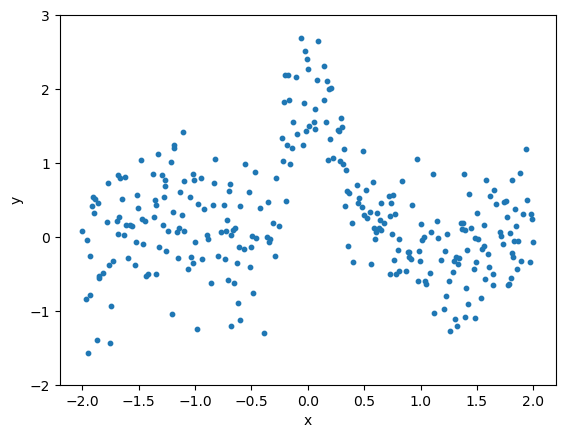

In [2]:
import matplotlib.pyplot as plt
plt.scatter(train_X,train_Y,marker='o',s=10)
plt.ylim(-2, 3)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('graph1.png')

### Linear Regression - Polynomial Transformation

Using the train data we hope to learn a relationship mapping $x$ to $y$. We can evaluate this mapping using the test data. Linear regression will try to fit a straight line (linear relation) mapping $x$ to $y$. However, we observe the $x$ and $y$ do not have a linear relationship. A straight line will not be a good fit. We need a non-linear mapping (curve) between $x$ and $y$. 

We discussed in the lecture that nonlinear regression can be achieved by transforming the scalar $x$ to a high dimension sample and performing linear regression with the transformed data. We can transform $x$ into a $d$ dimensional vector ($d \geq 2$) in order to perform nonlinear regression. For example, $d = 5$ transforms $x$ into a $(d+1)$ dimension vector $[1,x,x^2,x^3,x^4,x^5]^\top$, where $x^k$ is $x$ raised to $k$. In vectorized notation, the dataset $X$ is transformed to $\Phi(X)$ of  dimension $m \times (d+1)$, where $m$ is the number of samples. 

Every scalar $x$ is converted into a $(d+1)$ dimension vector, $[1,x_1,x_2,x_3,\ldots,x_d]^\top$. We can now perform linear regression in $(d+1)$ dimensions.
\begin{equation*}
y = \Phi(x)\boldsymbol{\theta} = \theta_0 + x_1\theta_1 + ... + x_{d-1}\theta_{d-1} + x_d\theta_d\\
\end{equation*}
In the above equation, $y$ is the target variable, $\boldsymbol{\theta} = [\theta_{0},.., \theta_{d}]^\top$ are the parameters/weights of the model, $\Phi(x) = [1,x_{1},.., x_{d}]$ is the transformed data point in the row vector format, where $x_k$ is the $k^{th}$ component. 
    
In the vectorized notation, the linear regression for $m$ samples is written as  $\hat{Y} = \Phi(X)\boldsymbol{\theta}$, where $\Phi(X)$ has the data points as row vectors and is of dimensions $m \times (d+1)$,

\begin{align}
\begin{bmatrix} \hat{y}^{(1)} \\ 
\hat{y}^{(2)}\\
\vdots\\ 
\hat{y}^{(m)}
\end{bmatrix} = 
\begin{bmatrix} 1 & x^{(1)}_1 & x^{(1)}_2  & \ldots & x^{(1)}_d\\ 
1 & x^{(2)}_1 & x^{(2)}_2  & \ldots & x^{(2)}_d\\  
\vdots & \vdots & \vdots & \vdots & \vdots\\ 
1 & x^{(m)}_1 & x^{(m)}_2  & \ldots & x^{(m)}_d\\ 
\end{bmatrix}
\begin{bmatrix} \theta_0 \\ 
\theta_1\\ 
\vdots \\ 
\theta_d\\ 
\end{bmatrix}
\end{align}




$X$ - is the Design matrix of dimension $m \times (d+1) $, where $m$ is the number of samples and $d$ is the degree of the polynomial that we are trying to fit. The first column of 1's in the design matrix will account for the bias , resulting in $d+1$ dimensions <br>

$Y$ - Vector of the prediction labels of dimension $m \times 1 $.
Lets implement a function to achieve this transformation.

In [3]:
def poly_transform(X,d):
    '''
    Function to transform scalar values into (d+1)-dimension vectors. 
    Each scalar value x is transformed a vector [1,x,x^2,x^3, ... x^d]. 
    
    Inputs:
        X: vector of m scalar inputs od shape (m, 1) where each row is a scalar input x
        d: number of dimensions
        
    Outputs:
        Phi: Transformed matrix of shape (m, (d+1)) 
    '''
    Phi = np.ones((X.shape[0],1))
    for i in range(1,d+1):
        col = np.power(X,i)
        Phi = np.hstack([Phi,col])
    return Phi

### Linear Regression - Objective Function (5 Points)

Let us define the objective function that will be optimized by the linear regression model.
    \begin{equation*}
    L\big(\Phi(X),Y,\theta\big) = \big(Y-\Phi(X)\boldsymbol{\theta}\big)^\top \big(Y-\Phi(X)\boldsymbol{\theta}\big)
    \end{equation*}

Here, $\Phi(X)$ is the design matrix of dimensions (m \times (d+1)) and $Y$ is the $m$ dimension vector of labels. 
$\theta$ is the $(d+1)$ dimension vector of weight parameters.
 
Hint: You may want to use [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) 

In [4]:
def lin_reg_obj(Y,Phi,theta):
    '''
    Objective function to estimate loss for the linear regression model.
    Inputs:
        Phi: Design matrix of dimensions (m, (d+1))
        Y: ground truth labels of dimensions (m, 1)
        theta: Parameters of linear regression of dimensions ((d+1),1)
        
    outputs:
        loss: scalar loss 
    '''
    # your code here
    l1=(Y -np.matmul(Phi,theta)).T
    l2= Y -np.matmul(Phi,theta)
    loss = np.matmul(l1,l2)
    # return loss
    return loss

In [5]:
# Run this cell to test the function
random.seed(1)
np.random.seed(1)
m1 = 10;
d1 = 5;
X_t = np.random.randn(m1,1)
Y_t = np.random.randn(m1,1)
theta_t = np.random.randn((d1+1),1)
PHI_t = poly_transform(X_t,d1)
loss_est = lin_reg_obj(Y_t,PHI_t,theta_t)

### Linear Regression - Closed Form Solution (10 Points)

Let us define a closed form solution to the objective function. Feel free to revisit the lecture to review the topic.
Closed form solution is given by,

\begin{equation*}
\theta = \big(\Phi(X)^\top\Phi(X)\big)^{-1}\Phi(X)^\top Y
\end{equation*}

Here $\Phi(X)$ is the $(m \times (d+1))$ dimension design matrix obtained using *poly_transform* function defined earlier and $Y$ are the ground truth labels of dimensions $(m \times 1)$. 

Hint: You may want to use [numpy.linalg.inv](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) and [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html).

In [6]:
def lin_reg_fit(Phi_X,Y):
    '''
    A function to estimate the linear regression model parameters using the closed form solution.
    Inputs:
        Phi_X: Design matrix of dimensions (m, (d+1))
        Y: ground truth labels of dimensions (m, 1)
         
    Outputs:
        theta: Parameters of linear regression of dimensions ((d+1),1)
    '''
    # your code here
    part1_no_inv = np.matmul(Phi_X.T,Phi_X)
    part1 = np.linalg.inv(part1_no_inv)
    part2  = np.matmul(Phi_X.T,Y)
    theta=np.matmul(part1, part2)
    # return theta
    return theta
    

In [7]:
# Run this cell to test the function
random.seed(1)
np.random.seed(1)
m1 = 10;
d1 = 5;
X_t = np.random.randn(m1,1)
Y_t = np.random.randn(m1,1)
PHI_t = poly_transform(X_t,d1)
theta_est = lin_reg_fit(PHI_t,Y_t)

### Metrics for Evaluation (10 points)

We will evaluate the goodness of our linear regression model using root mean square error. This compares the difference between the estimate Y-labels and the groundth truth Y-labels. The smaller the RMSE value, better is the fit. 
1. RMSE (Root Mean Squared Error)
\begin{equation*}
\sqrt{\frac{1}{m}\sum_{i=1}^{m}(y\_pred^{(i)} - y^{(i)})^{2} }
\end{equation*}

Hint: You may want to use:  
[numpy.sqrt](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html),
[numpy.sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html) or [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html).

In [8]:
def get_rmse(Y_pred,Y):
    '''
    function to evaluate the goodness of the linear regression model.
    
    Inputs:
        Y_pred: estimated labels of dimensions (m, 1)
        Y: ground truth labels of dimensions (m, 1)
        
    Outputs:
        rmse: root means square error
    '''
    # your code here
    part1 = np.subtract(Y_pred, Y)
    m = len(Y_pred)
    rmse = np.sqrt(np.square(part1).sum()/m)
    # return rmse
    return rmse

In [9]:
# Run this cell to test the function
random.seed(1)
np.random.seed(1)
m1 = 50
Y_Pred_t = np.random.randn(m1,1)
Y_t = np.random.randn(m1,1)
rmse_est = get_rmse(Y_Pred_t,Y_t)

Let's visualize the nonlinear regression fit and the RMSE evaluation error on the test data

Train RMSE =  0.513634058973071
Test RMSE =  0.5037613976192088


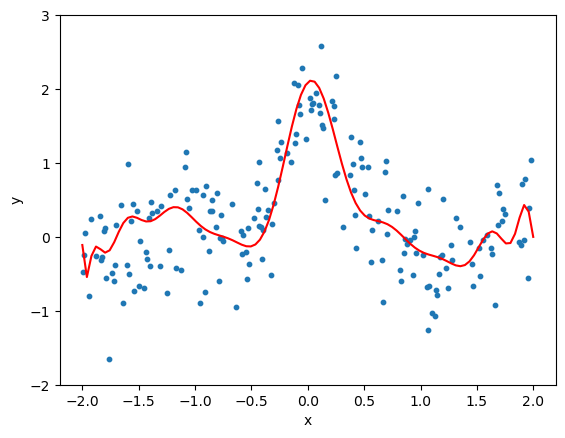

In [10]:
d = 20
Phi_X_tr = poly_transform(train_X,d)
theta = lin_reg_fit(Phi_X_tr,train_Y)
#Estimate the prediction on the train data
Y_Pred_tr = np.dot(Phi_X_tr,theta)
rmse = get_rmse(Y_Pred_tr,train_Y)
print('Train RMSE = ', rmse)

#Perform the same transform on the test data
Phi_X_ts = poly_transform(test_X,d)
#Estimate the prediction on the test data
Y_Pred_ts = np.dot(Phi_X_ts,theta)
#Evaluate the goodness of the fit
rmse = get_rmse(Y_Pred_ts,test_Y)
print('Test RMSE = ', rmse)

import matplotlib.pyplot as plt
plt.scatter(test_X,test_Y,marker='o',s=10)
# Sampling more points to plot a smooth curve
px = np.linspace(-2,2,100).reshape(-1,1)
PX = poly_transform(px,d)
py = np.dot(PX,theta)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 3)
plt.plot(px,py,color='red')
plt.savefig('graph2.png')

## 2. Ridge Regression 

The degree of the polynomial regression is $d=10$. Even though the curve appears to be smooth, it may be fitting to the noise. We will use Ridge Regression to get a smoother fit and avoid-overfitting. Recall the ridge regression objective form:

\begin{equation*}
    L\big(\Phi(X),Y,\theta, \lambda\big) = \big(Y-\Phi(X)\boldsymbol{\theta}\big)^\top \big(Y-\Phi(X)\boldsymbol{\theta}\big) + \lambda^2\boldsymbol{\theta}^\top\boldsymbol{\theta}
\end{equation*}
where, $\lambda\geq 0$ is the regularization parameter. Larger the value of $\lambda$, the more smooth the curve. The closed form solution to the objective is give by: 

\begin{equation*}
\theta = \big(\Phi(X)^\top\Phi(X) + \lambda^2I_d \big)^{-1}\Phi(X)^\top Y
\end{equation*}

Here, $I_d$ is the identity matrix of dimensions $((d+1) \times (d+1))$, $\Phi(X)$ is the $(m \times (d+1))$ dimension design matrix obtained using *poly_transform* function defined earlier and $Y$ are the ground truth labels of dimensions $(m \times 1)$. 

### Ridge Regression Closed Form Solution (5 points)

Similar to Linear regression, lets implement the closed form solution to ridge regression.

In [11]:
def ridge_reg_fit(Phi_X,Y,lamb_d):
    '''
    A function to estimate the ridge regression model parameters using the closed form solution.
    Inputs:
        Phi_X: Design matrix of dimensions (m, (d+1))
        Y: ground truth labels of dimensions (m, 1)
        lamb_d: regularization parameter
         
    Outputs:
        theta: Parameters of linear regression of dimensions ((d+1),1)
    '''
    #Step 1: get the dimension dplus1 using Phi_X to create the identity matrix $I_d$
    #Step 2: Estimate the closed form solution similar to *linear_reg_fit* but now includethe lamb_d**2*I_d term
    
    # your code here
    m, d = Phi_X.shape
    part1 = np.matmul(Phi_X.T,Phi_X)
    part2 = np.matmul(Phi_X.T,Y)
    lambsqua = np.power(lamb_d,2)
    lambwhole = np.dot(lambsqua,np.eye(d))
    theta = np.dot(np.linalg.inv(part1 + lambwhole),part2)
    #return theta
    return theta

In [12]:
# Run this cell to test your function  

random.seed(1)
np.random.seed(1)
m1 = 10;
d1 = 5;
lamb_d_t = 0.1
X_t = np.random.randn(m1,1)
Y_t = np.random.randn(m1,1)
PHI_t = poly_transform(X_t,d1)
theta_est = ridge_reg_fit(PHI_t,Y_t,lamb_d_t)

### Cross Validation to Estimate ($\lambda$)

In order to avoid overfitting when using a high degree polynomial, we have used **ridge regression**. We now need to estimate the optimal value of $\lambda$ using **cross-validation**.

We will obtain a generic value of $\lambda$ using the entire training dataset to validate. We will employ the method of **$k$-fold cross validation**, where we split the training data into $k$ non-overlapping random subsets. In every cycle, for a given value of $\lambda$, $(k-1)$ subsets are used for training the ridge regression model and the remaining subset is used for evaluating the goodness of the fit. We estimate the average goodness of the fit across all the subsets and select the $lambda$ that results in the best fit.

![K-fold cross validation](images/kfold.png)

It is easier to shuffle the index and slice the training into required number of segments, than processing the complete dataset. The below function **k_val_ind$()$** returns a 2D list of indices by spliting the datapoints into  '$k\_fold$'  sets

Refer the following documentation for splitting and shuffling:

- https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.shuffle.html
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html


In [13]:
def k_val_ind(index,k_fold,seed=1):
    '''
    Function to split the data into k folds for cross validation. Returns the indices of the data points 
    belonging to every split.
    
    Inputs:
        index: all the indices of the training
        k_fold: number of folds to split the data into
    
    Outputs:
        k_set: list of arrays with indices
    ''' 
    np.random.seed(seed)
    np.random.shuffle(index) # Shuffle the indices
    k_set = np.split(index,k_fold) # Split the indices into 'k_fold' 
    return k_set

### K- Fold Cross Validation (10 Points)

Let's now implement $k$-fold cross validation.

In [14]:
def k_fold_cv(k_fold,train_X,train_Y,lamb_d,d):
    '''
    Function to implement k-fold cross validation.
    Inputs:
        k_fold: number of validation subsests
        train_X: training data of dimensions (m, 1) 
        train_Y: ground truth training labels
        lamb_d: ridge regularization lambda parameter
        d: polynomial degree
        
    Outputs:
        rmse_list: list of root mean square errors (RMSE) for k_folds 
    '''
    index = np.arange(train_X.shape[0]) # indices of the training data
    k_set = k_val_ind(index,k_fold) # pre-defined function to shuffle and split indices 

    Phi_X = poly_transform(train_X, d) #transform all the data to (m,(d+1)) dimensions
    rmse_list = [] 
    for i in range(k_fold):
        ind = np.zeros(train_X.shape[0], dtype=bool) # binary mask
        ind[k_set[i]] = True # validation portion is indicated

        #Note: Eg. train_X[ind] -> validation set, train_X[~ind] -> training set 
        # Write your answer inside the 'for' loop
        # Note: Phi_X[~ind,:] is training subset and Phi_X[ind,:] is validation subset. Similary for the train and validation labels.
        # Step 1: Estimate the theta parameter using ridge_reg_fit with the training subset, training labels and lamb_d
        # Step 2: Estimate the prediction Y_pred over the validation as a dot product over Phi_X[ind,:] and theta
        # Step 3: use 'get_rmse' function to determine rmse using Y_pred and train_Y[ind]
        
        # your code here
        Phi_X = poly_transform(train_X[~ind],d) 
        Phi_X_val = poly_transform(train_X[ind],d) 
        theta = ridge_reg_fit(Phi_X, train_Y[~ind],lamb_d)
        
        Y_pred = np.dot(Phi_X_val, theta) 
        rmse=get_rmse(Y_pred,train_Y[ind])
        rmse_list.append(rmse)
        
    return rmse_list

In [15]:
# Run this cell to test the function
np.random.seed(1)
m1 = 20;
d1 = 5;
k_fold_t = 5 # number of portions to split the training data
lamb_d_t = 0.1
X_t = np.random.randn(m1,1)
Y_t = np.random.randn(m1,1)

rmse_list_est = k_fold_cv(k_fold_t,X_t,Y_t,lamb_d_t,d1)

Let us select the value of $\lambda$ that provides the lowest error based on RMSE returned by the 'k_fold_cv' function.

In this example, we will choose the best value of $\lambda$ among 6 values.

In [16]:
k_fold = 5
d = 20
l_range = [0,1e-3,1e-2,1e-1,1,10] # The set of lamb_d parameters used for validation.
th = float('inf')
for lamb_d in l_range:     
    print('lambda:'+str(lamb_d))
    rmse = k_fold_cv(k_fold,train_X,train_Y,lamb_d,d)
    print("RMSE: ",rmse)
    print("*************")
    mean_rmse = np.mean(rmse)
    if mean_rmse<th:
        th = mean_rmse
        l_best = lamb_d

print("Best value for the regularization parameter(lamb_d):",l_best)

lambda:0
RMSE:  [0.9006072442019392, 0.5994604324421956, 0.4890207345278066, 0.5735790161125889, 0.5778385250430557]
*************
lambda:0.001
RMSE:  [0.9255520584502497, 0.601876815684804, 0.48870216206846856, 0.5708885593319465, 0.578445847591477]
*************
lambda:0.01
RMSE:  [1.0459060774221536, 0.6251810228249165, 0.4933197059851526, 0.5570577128851374, 0.5899592385661795]
*************
lambda:0.1
RMSE:  [0.8261476324642023, 0.646524807784787, 0.4903311825426942, 0.5660953409782714, 0.5945669719328042]
*************
lambda:1
RMSE:  [0.6799665161702088, 0.6886693537583723, 0.5647357353316835, 0.6393075339866027, 0.6470329242394136]
*************
lambda:10
RMSE:  [0.7335261034660037, 0.6993069185624117, 0.755613249446772, 0.7992608695037103, 0.8199075004506737]
*************
Best value for the regularization parameter(lamb_d): 0.1


### Evaluation on the Test Set (10 Points)

As discussed in previous section, we will present the final evaluation of the model based on the test set.

In [17]:
lamb_d = l_best

# Step 1: Create Phi_X using 'poly_transform(.)' on the train_X and d=20
# Step 2: Estimate theta using ridge_reg_fit(.) with Phi_X, train_Y and the best lambda
# Step 3: Create Phi_X_test using 'poly_transform(.)' on the test_X and d=20
# Step 4: Estimate the Y_Pred for the test data using Phi_X_test and theta
# Step 5: Estimate rmse using get_rmse(.) on the Y_Pred and test_Y 

# your code here
Phi_X_tra = poly_transform(train_X, 20)
theta = ridge_reg_fit(Phi_X_tra, train_Y, lamb_d)
Phi_X_test = poly_transform(test_X, 20)
Y_pred = np.dot(Phi_X_test, theta)
rmse = get_rmse(Y_pred, test_Y)
print("RMSE on test set is " + str(rmse))

RMSE on test set is 0.49850115663643557


Let's visualize the model's prediction on the test data set.

Test RMSE =  0.49850115663643557


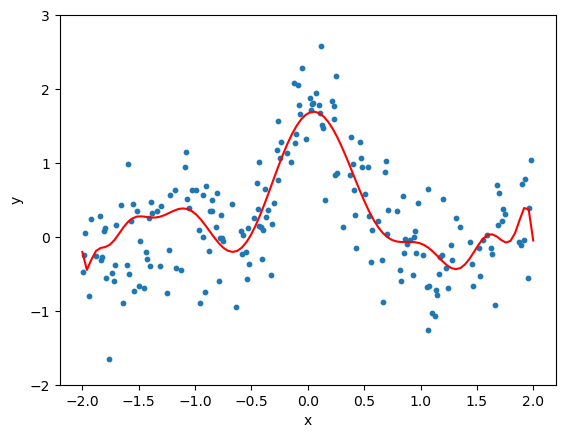

In [18]:
print('Test RMSE = ', rmse)

plt.scatter(test_X,test_Y,marker='o',s=10)
# Sampling more points to plot a smooth curve
px = np.linspace(-2,2,100).reshape(-1,1)
PX = poly_transform(px,d)
py = np.dot(PX,theta)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 3)
plt.plot(px,py,color='red')
plt.savefig('graph3.png')

You have completed linear ridge regression and estimated the best value for the regularization parameter $\lambda$ using k-fold cross validation. 

# Section II - Logistic Regression

Machine learning is used in medicine for assisting doctors with crucial decision-making based on dignostic data. 
In this assignment we will be designing a logistic regression model (single layer neural network) to predict if a subject is diabetic or not. The model will classify the subjects into two groups diabetic (Class 1) or non-diabetic (Class 0) - a binary classification model.

We will be using the 'Pima Indians Diabetes dataset' to train our model which contains different clinical parameters (features) for multiple subjects along with the label (diabetic or not-diabetic). Each  subject is represented by 8 features (Pregnancies, Glucose, Blood-Pressure, SkinThickness, Insulin, BMI, Diabetes-Pedigree-Function, Age) and the 'Outcome' which is the class label. The dataset contains the results from 768 subjects.

We will be spliting the dataset into train and test data. We will train our model on the train data and predict the categories on the test data. 

In [19]:
#importing a few libraries
import numpy as np
from datasets import pima_data
import sys
import matplotlib.pyplot as plt
import numpy.testing as npt

## 1. Load Data, Visualize and Normalize

Let us load the training and test data.

In [20]:
train_X,train_Y,test_X,test_Y  = pima_data()

print('train_X.shape = ', train_X.shape)
print('train_Y.shape = ', train_Y.shape)
print('test_X.shape = ', test_X.shape)
print('test_Y.shape = ', test_Y.shape)

# Lets examine the data
print('\nFew Train data examples')
print(train_X[:5, :])
print('\nFew Train data labels')
print(train_Y[:5])

train_X.shape =  (500, 8)
train_Y.shape =  (500,)
test_X.shape =  (268, 8)
test_Y.shape =  (268,)

Few Train data examples
[[6.000e+00 1.480e+02 7.200e+01 3.500e+01 0.000e+00 3.360e+01 6.270e-01
  5.000e+01]
 [1.000e+00 8.500e+01 6.600e+01 2.900e+01 0.000e+00 2.660e+01 3.510e-01
  3.100e+01]
 [8.000e+00 1.830e+02 6.400e+01 0.000e+00 0.000e+00 2.330e+01 6.720e-01
  3.200e+01]
 [1.000e+00 8.900e+01 6.600e+01 2.300e+01 9.400e+01 2.810e+01 1.670e-01
  2.100e+01]
 [0.000e+00 1.370e+02 4.000e+01 3.500e+01 1.680e+02 4.310e+01 2.288e+00
  3.300e+01]]

Few Train data labels
[1. 0. 1. 0. 1.]


In [21]:
# We notice the data is not normalized. Lets do a simple normalization scaling to data between 0 and 1
# Normalized data is easier to train using large learning rates
train_X = np.nan_to_num(train_X/train_X.max(axis=0))
test_X = np.nan_to_num(test_X/test_X.max(axis=0))

#Lets reshape the data so it matches our notation from the lecture. 
#train_X should be (d, m) and train_Y should (1,m) similarly for test_X and test_Y
train_X = train_X.T
train_Y= train_Y.reshape(1,-1)

test_X = test_X.T
test_Y= test_Y.reshape(1,-1)
print('train_X.shape = ', train_X.shape)
print('train_Y.shape = ', train_Y.shape)
print('test_X.shape = ', test_X.shape)
print('test_Y.shape = ', test_Y.shape)

# Lets examine the data and verify it is normalized
print('\nFew Train data examples')
print(train_X[:, :5])
print('\nFew Train data labels')
print(train_Y[0,:5])

train_X.shape =  (8, 500)
train_Y.shape =  (1, 500)
test_X.shape =  (8, 268)
test_Y.shape =  (1, 268)

Few Train data examples
[[0.35294118 0.05882353 0.47058824 0.05882353 0.        ]
 [0.74371859 0.42713568 0.91959799 0.44723618 0.68844221]
 [0.59016393 0.54098361 0.52459016 0.54098361 0.32786885]
 [0.35353535 0.29292929 0.         0.23232323 0.35353535]
 [0.         0.         0.         0.11111111 0.19858156]
 [0.50074516 0.39642325 0.34724292 0.41877794 0.64232489]
 [0.25909091 0.14504132 0.27768595 0.06900826 0.94545455]
 [0.61728395 0.38271605 0.39506173 0.25925926 0.40740741]]

Few Train data labels
[1. 0. 1. 0. 1.]


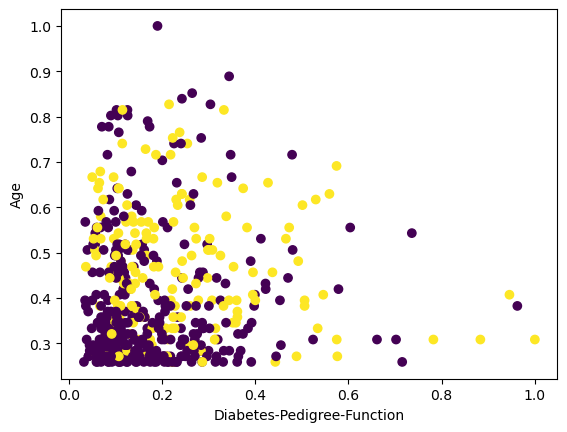

In [22]:
#There are 8 features for each of the data points. Lets plot the data using a couple of features
fig, ax = plt.subplots()
plt.scatter(train_X[6,:],train_X[7,:], c=train_Y[0])
plt.xlabel('Diabetes-Pedigree-Function')
plt.ylabel('Age')
plt.savefig('graph4.png')
# We have plotted train_X[6,:],train_X[7,:]. 
# Feel free to insert your own cells to plot and visualize different variable pairs. 

## 2. Quick Review of the Steps Involved in Logistic Regression Using Gradient Descent.

1. Training data $X$ is of dimensions $(d \times m)$ where $d$ is number of features and $m$ is number of samples. Training labels $Y$ is of dimensions $(1 \times m)$. 

2. Initilaize logistic regression model parameters $w$ and $b$ where $w$ is of dimensions $(d, 1)$ and $b$ is a scalar. $w$ is initialized to small random values and $b$ is set to zero

3. Calculate $Z$ using $X$ and intial parameter values $(w , b)$ 
<center> 
    \begin{equation*}
     Z= w^\top X + b
    \end{equation*}
</center>

4. Apply the sigmoid activation to estimate $A$ on $Z$,
<center> 
    \begin{equation*}
     A=\frac{1}{1+\text{exp}(-Z)}
    \end{equation*}
</center>

5. Calculate the loss $L()$ between predicted probabilities $A$ and groundtruth labels $Y$,
<center> 
    \begin{equation*}
     loss = logistic\_loss(A,Y)
    \end{equation*}
</center>

4. Calculate gradient dZ (or $\frac{dL}{dZ}$),
<center> 
    \begin{equation*}
     dZ = (A - Y)
    \end{equation*}
</center>

5. Calculate gradients $\frac{dL}{dw}$ represented by $dw$, $\frac{dL}{db}$ represented by $db$
<center> 
    \begin{equation*}
     dw,db = grad\_fn(X ,dZ)
    \end{equation*}
</center>
6. Adjust the model parameters using the gradients. Here $\alpha$ is the learning rate.
<center> 
    \begin{equation*}
     w := w - \alpha.dw\\
     b := b - \alpha.db
    \end{equation*}
</center>
7. Loop until the loss converges or for a fixed number of epochs. 
We will first define the functions **logistic_loss()** and **grad_fn()** along with other functions below. 

# Review

![Lecture Notes](images/lecture_notes.png)

### Intialize Parameters (5 Points)

we will initialize the model parameters. The weights will be initialized with small random values and bias as 0. While the bias will be a scalar, the dimension of weight vector will be $(d \times 1)$, where $d$ is the number of features.


Hint:[np.random.randn](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randn.html) can be used here to create a vector of random integers of desired shape.

In [23]:
def initialize(d, seed=1):
    '''
    Function to initialize the parameters for the logisitic regression model
    
    Inputs:
        d: number of features for every data point
        seed: random generator seed for reproducing the results
        
    Outputs:
        w: weight vector of dimensions (d, 1)
        b: scalar bias value
    '''
    np.random.seed(seed)
    
    # NOTE: initialize w to be a (d,1) column vector instead of (d,) vector 
    # Hint: initialize w to a random vector with small values. For example, 0.01*np.random.randn(.) can be used.
    #       and initialize b to scalar 0
    
    # your code here 
    w = np.random.randn(d,1)  
    b = 0.0
    #return w,b
    return w,b

### Sigmoid Function (5 Points)

Let's now implement Sigmoid activation function.

<center> 
    \begin{equation*}
    \sigma \left(z\right) = \frac{1}{1+\text{exp}(-z)}
    \end{equation*}
</center>

where z is in the input variable.
Hint: [numpy.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html) can be used for defining the exponential function.

In [24]:
def sigmoid(z):
    # your code here
    A = 1/(1 + np.exp(-z))
    # return A
    return A

### Logistic Loss Function (5 Points)

We will define the objective function that will be used later for determining the loss between the model prediction and groundtruth labels. We will use vectors $A$ (activation output of the logistic neuron) and $Y$ (groundtruth labels) for defining the loss. 

<center> 
    \begin{equation*}
    L(A,Y) = -\frac{1}{m}\sum_{i =1}^{m}y^{(i)}\text{log} a^{(i)} + (1-y^{(i)}) \text{log}( 1 - a^{(i)})
    \end{equation*}
</center>

where $m$ is the number of input datapoints and is used for averaging the total loss.
Hint: [numpy.sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html) and [numpy.log](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html).

In [25]:
def logistic_loss(A,Y):
    '''
    Function to calculate the logistic loss given the predictions and the targets.
    
    Inputs:
        A: Estimated prediction values, A is of dimension (1, m)
        Y: groundtruth labels, Y is of dimension (1, m)
        
    Outputs:
        loss: logistic loss
    '''
    a = A.shape[1]
    # your code here
    loss = - 1/a * np.sum((Y * np.log(A) + (1 - Y) * np.log(1 - A)))
    #return loss
    return loss

### Gradient Function (5 Points)

Let us define the gradient function for calculating the gradients ($\frac{dL}{dw},\frac{dL}{db}$). We will use it during gradient descent.

The gradients can be calculated as,
<center> 
    \begin{equation*}
    dw = \frac{1}{m}X( A- Y)^{T}\\
    db = \frac{1}{m}\sum_{i =1}^{m} (a^{(i)} - y^{(i)})
    \end{equation*}
</center>

Instead of $(A-Y)$, we will use dZ (or $\frac{dL}{dZ}$) since,
<center> 
    \begin{equation*}
    dZ = \left( A- Y\right)
    \end{equation*}
</center>
Make sure the gradients are of correct dimensions. Refer to lecture for more information.

Hint: [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) and
[numpy.sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html). Check use of 'keepdims' parameter.

In [26]:
def grad_fn(X,dZ):
    '''
    Function to calculate the gradients of weights (dw) and biases (db) w.r.t the objective function L.
    
    Inputs:
        X: training data of dimensions (d, m)
        dZ: gradient dL/dZ where L is the logistic loss and Z = w^T*X+b is the input to the sigmoid activation function
            dZ is of dimensions (1, m)
        
    outputs:
        dw: gradient dL/dw - gradient of the weight w.r.t. the logistic loss. It is of dimensions (d,1)
        db: gradient dL/db - gradient of the bias w.r.t. the logistic loss. It is a scalar
    '''
    m = X.shape[1]
    # your code her
    dw = 1/m * np.dot(X, dZ.T)
    db = np.reshape(1/m * np.sum(dZ), (1,1))
    # return dw,db
    return dw,db

### Training the Model (10 Points)

We will now implement the steps for gradient descent discussed earlier.

In [27]:
def model_fit(w,b,X,Y,alpha,n_epochs,log=False):
    '''
    Function to fit a logistic model with the parameters w,b to the training data with labels X and Y.
    
    Inputs:
        w: weight vector of dimensions (d, 1)
        b: scalar bias value
        X: training data of dimensions (d, m)
        Y: training data labels of dimensions (1, m)
        alpha: learning rate
        n_epochs: number of epochs to train the model
        
    Outputs:
        params: a dictionary to hold parameters w and b
        losses: a list train loss at every epoch
    '''
    nw=w
    nb=b
    losses=[]
    for epoch in range(n_epochs):
        
        # Implement the steps in the logistic regression using the functions defined earlier.
        # For each iteration of the for loop
            # Step 1: Calculate output Z = w.T*X + b
            # Step 2: Apply sigmoid activation: A = sigmoid(Z)
            # Step 3: Calculate loss = logistic_loss(.) between predicted values A and groundtruth labels Y
            # Step 4: Estimate gradient dZ = A-Y
            # Step 5: Estimate gradients dw and db using grad_fn(.).
            # Step 6: Update parameters w and b using gradients dw, db and learning rate
            #         w = w - alpha * dw
            #         b = b - alpha * db

       # your code here
        Z = np.matmul(nw.T, X) + nb 
        A = sigmoid(Z)
        loss = logistic_loss(A,Y)
        dZ = (A-Y)
        dw, db = grad_fn(X,dZ) 
        nw = nw - alpha * dw
        nb = nb - alpha * db
        if epoch%100 == 0:
            losses.append(loss)
            if log == True:
                print("%i iter: loss = %f"%(epoch,loss))
    params ={"w":nw,"b":nb}
    
    return params,losses    

### Model Prediction (10 Points)

Once we have the optimal values of model parameters $(w,b)$, we can determine the accuracy of the model on the test data.

\begin{equation*}
Z = w^{T}X + b
\end{equation*}

\begin{equation*}
A=\sigma\left(Z\right)  
\end{equation*}


In [28]:
def model_predict(params,X,Y=np. array([]),pred_threshold=0.5):
    '''
    Function to calculate category predictions on given data and returns the accuracy of the predictions.
    Inputs:
        params: a dictionary to hold parameters w and b
        X: training data of dimensions (d, m)
        Y: training data labels of dimensions (1, m). If not provided, the function merely makes predictions on X
        
    outputs:
        Y_Pred: Predicted class labels for X. Has dimensions (1, m)
        acc: accuracy of prediction over X if Y is provided else, 0 
        loss: loss of prediction over X if Y is provided else, Inf  
    '''
    w = params['w']
    b = params['b']
    m = X.shape[1]
    
    # Calculate Z using X, w and b
    # Calculate A using the sigmoid - A is the set of (1,m) probabilities
    # Calculate the prediction labels Y_Pred of size (1,m) using A and pred_threshold 
    # When A>pred_threshold Y_Pred is 1 else 0
    
    # your code here
    nZ = np.matmul(w.T, X) + b
    nA = sigmoid(nZ) 
    nY_Pred=np.zeros((1,m))
    for i in range(m):
        if nA[0][i]>pred_threshold:
            nY_Pred[0][i] = 1 
        else:
            nY_Pred[0][i]= 0 
    if len(Y)==0:
        loss = float('inf')
        acc = 0
    if Y.size!=0:
        loss = logistic_loss(nA,Y)
        acc = np.mean(nY_Pred==Y)
    return nY_Pred, acc, loss

## 3. Putting it All Together (10 Points)

We will train our logistic regression model using the data we have loaded and test our predictions on diabetes classification.

0 iter: loss = 0.765411
100 iter: loss = 0.652098
200 iter: loss = 0.631494
300 iter: loss = 0.613999
400 iter: loss = 0.599052
500 iter: loss = 0.586199
600 iter: loss = 0.575075
700 iter: loss = 0.565386
800 iter: loss = 0.556895
900 iter: loss = 0.549412
1000 iter: loss = 0.542782
1100 iter: loss = 0.536880
1200 iter: loss = 0.531601
1300 iter: loss = 0.526861
1400 iter: loss = 0.522589
1500 iter: loss = 0.518725
1600 iter: loss = 0.515219
1700 iter: loss = 0.512028
1800 iter: loss = 0.509117
1900 iter: loss = 0.506453
Train Accuracy of the model: 0.77
Test Accuracy of the model: 0.7611940298507462


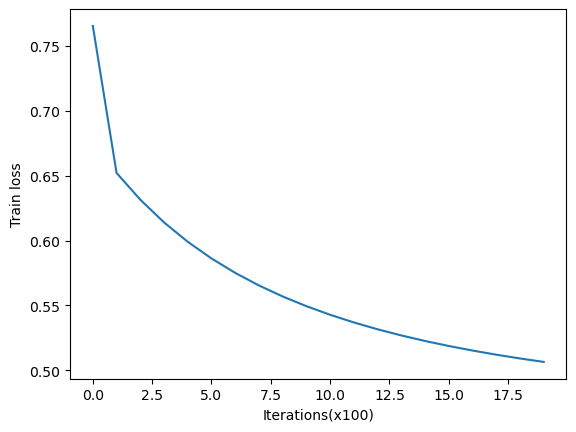

In [29]:
#We can use a decently large learning rate becasue the features have been normalized 
#When features are not normalized, larger learning rates may cause the learning to oscillate 
#and go out of bounds leading to 'nan' errors
#Feel free to adjust the learning rate alpha and the n_epochs to vary the test accuracy
#You should be able to get test accuracy > 70%
#You can go up to 75% to 80% test accuracies as well

alpha = 0.2
n_epochs = 2000

# Write code to initialize parameters w and b with initialize(.) (use train_X to get feature dimensions d)
# Use model_fit(.) to estimate the updated 'params' of the logistic regression model and calculate how the 'losses' varies 
# Use variables 'params' and 'losses' to store the outputs of model_fit(.) 

# your code here
w,b = initialize(train_X.shape[0])
params,losses = model_fit(w,b,train_X,train_Y,alpha,n_epochs,log=True)

Y_Pred_tr, acc_tr, loss_tr = model_predict(params,train_X,train_Y)
Y_Pred_ts, acc_ts, loss_ts = model_predict(params,test_X,test_Y)
print("Train Accuracy of the model:",acc_tr)
print("Test Accuracy of the model:",acc_ts)
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Iterations(x100)')
plt.ylabel('Train loss')
plt.savefig('graph5.png')